In [9]:
# load dataframe
import pandas as pd
bbc_df = pd.read_csv("../BBC_articles/bbc_df.csv")

## Best results: Knowledge graph with Coreference resolution

In [10]:
import pandas as pd
import re
import spacy
import neuralcoref

nlp = spacy.load('en_core_web_lg')
neuralcoref.add_to_pipe(nlp)


def get_entity_pairs(text, coref=True):
    # preprocess text
    text = re.sub(r'\n+', '.', text)  # replace multiple newlines with period
    text = re.sub(r'\[\d+\]', ' ', text)  # remove reference numbers
    text = nlp(text)
    if coref:
        text = nlp(text._.coref_resolved)  # resolve coreference clusters

    def refine_ent(ent, sent):
        unwanted_tokens = (
            'PRON',  # pronouns
            'PART',  # particle
            'DET',  # determiner
            'SCONJ',  # subordinating conjunction
            'PUNCT',  # punctuation
            'SYM',  # symbol
            'X',  # other
        )
        ent_type = ent.ent_type_  # get entity type
        if ent_type == '':
            ent_type = 'NOUN_CHUNK'
            ent = ' '.join(str(t.text) for t in nlp(str(ent)) if t.pos_ not in unwanted_tokens and t.is_stop == False)
            
        elif ent_type in ('CARDINAL', 'ORDINAL') and str(ent).find(' ') == -1:
            refined = ''
            for i in range(len(sent) - ent.i):
                if ent.nbor(i).pos_ not in ('VERB', 'PUNCT'):
                    refined += ' ' + str(ent.nbor(i))
                else:
                    ent = refined.strip()
                    break

        return ent, ent_type

    sentences = [sent.string.strip() for sent in text.sents]  # split text into sentences
    ent_pairs = []
    for sent in sentences:
        sent = nlp(sent)
        spans = list(sent.ents) + list(sent.noun_chunks)  # collect nodes
        spans = spacy.util.filter_spans(spans)
        with sent.retokenize() as retokenizer:
            [retokenizer.merge(span, attrs={'tag': span.root.tag,
                                            'dep': span.root.dep}) for span in spans]
            
            
        deps = [token.dep_ for token in sent]

        # limit our example to simple sentences with one subject and object
        if (deps.count('obj') + deps.count('dobj')) != 1\
                or (deps.count('subj') + deps.count('nsubj')) != 1:
            continue

        for token in sent:
            if token.dep_ not in ('obj', 'dobj'):  # identify object nodes
                continue
            subject = [w for w in token.head.lefts if w.dep_
                       in ('subj', 'nsubj')]  # identify subject nodes
            if subject:
                subject = subject[0]
                # identify relationship by root dependency
                relation = [w for w in token.ancestors if w.dep_ == 'ROOT']
                if relation:
                    relation = relation[0]
                    # add adposition or particle to relationship
                    if relation.nbor(1).pos_ in ('ADP', 'PART'):
                        relation = ' '.join((str(relation), str(relation.nbor(1))))
                else:
                    relation = 'unknown'

                subject, subject_type = refine_ent(subject, sent)
                token, object_type = refine_ent(token, sent)

                ent_pairs.append([str(subject), str(relation), str(token), str(sent),
                                  str(subject_type), str(object_type)])

    ent_pairs = [sublist for sublist in ent_pairs
                          if not any(str(ent) == '' for ent in sublist)]
    pairs = pd.DataFrame(ent_pairs, columns=['subject', 'relation', 'object','sentence',
                                             'subject_type', 'object_type'])
    print('Entity pairs extracted:', str(len(ent_pairs)))

    return pairs

In [11]:
    
cols = ['subject', 'relation', 'object','sentence','subject_type', 'object_type']
kg_new = pd.DataFrame(columns=cols)

for index, row in bbc_df.iterrows():
    if(isinstance(row['text'], str)):
        df_temp = get_entity_pairs(row['text'])
        kg_new = kg_new.append(df_temp, ignore_index=True)


Entity pairs extracted: 3
Entity pairs extracted: 4
Entity pairs extracted: 0
Entity pairs extracted: 1
Entity pairs extracted: 8
Entity pairs extracted: 1
Entity pairs extracted: 0
Entity pairs extracted: 0
Entity pairs extracted: 2
Entity pairs extracted: 6
Entity pairs extracted: 2
Entity pairs extracted: 3
Entity pairs extracted: 2
Entity pairs extracted: 5
Entity pairs extracted: 5
Entity pairs extracted: 2
Entity pairs extracted: 0
Entity pairs extracted: 1
Entity pairs extracted: 2
Entity pairs extracted: 3
Entity pairs extracted: 2
Entity pairs extracted: 5
Entity pairs extracted: 1
Entity pairs extracted: 3


In [14]:
# saving the dataframe
kg_new.to_csv('kg_coref.csv')

In [13]:
kg_new.head(10)

,subject,relation,object,sentence,subject_type,object_type
0,The World Meteorological Organization,verified,record,The World Meteorological Organization (WMO) on...,ORG,NOUN_CHUNK
1,greenhouse gases,cause,warming,These greenhouse gases can cause further warmi...,NOUN_CHUNK,NOUN_CHUNK
2,humans,experience,catastrophic warming,"Left unchecked, humans and nature will experie...",NOUN_CHUNK,NOUN_CHUNK
3,Thwaites,dumping,50 billion tonnes,Already Thwaites is dumping 50 billion tonnes ...,ORG,QUANTITY
4,coming change,see,following ice jump,The coming change in status will probably see ...,NOUN_CHUNK,NOUN_CHUNK
5,year ITGC project,putting,Thwaites,Jointly funded by the US National Science Foun...,NOUN_CHUNK,ORG
6,teams,investigating,glacier behaviour,"Each Antarctic summer season, teams of scienti...",NOUN_CHUNK,NOUN_CHUNK
7,The EU,tightened,EU restrictions,The EU has similarly tightened The EU restrict...,ORG,NOUN_CHUNK
8,plant,emit,more than seven million tonnes,This plant alone will emit more than seven mil...,NOUN_CHUNK,QUANTITY
9,Japan gas fired power stations,doing,lot,In a lot of resistance place Japan's gas-fired...,NOUN_CHUNK,NOUN_CHUNK


## Other methods tested

https://www.analyticsvidhya.com/blog/2019/10/how-to-build-knowledge-graph-text-using-spacy/

In [15]:
import re
import pandas as pd
import bs4
import requests
import spacy
import nltk
from spacy import displacy

nlp = spacy.load('en_core_web_sm')

from spacy.matcher import Matcher 
from spacy.tokens import Span 

import networkx as nx

import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np

# pd.set_option('display.max_colwidth', 200)
%matplotlib inline

def get_entities(sent):
    
    ## chunk 1
    ent1 = ""
    ent2 = ""

    prv_tok_dep = ""    # dependency tag of previous token in the sentence
    prv_tok_text = ""   # previous token in the sentence

    prefix = ""
    modifier = ""

    #############################################################
  
    for tok in nlp(sent):
        ## chunk 2
        # if token is a punctuation mark then move on to the next token
        if tok.dep_ != "punct":
            # check: token is a compound word or not
            if tok.dep_ == "compound":
                prefix = tok.text
                # if the previous word was also a 'compound' then add the current word to it
                if prv_tok_dep == "compound":
                    prefix = prv_tok_text + " "+ tok.text
      
            # check: token is a modifier or not
            if tok.dep_.endswith("mod") == True:
                modifier = tok.text
                # if the previous word was also a 'compound' then add the current word to it
                if prv_tok_dep == "compound":
                    modifier = prv_tok_text + " "+ tok.text
      
        ## chunk 3
        if tok.dep_.find("subj") == True:
            ent1 = modifier +" "+ prefix + " "+ tok.text
            prefix = ""
            modifier = ""
            prv_tok_dep = ""
            prv_tok_text = ""      

        ## chunk 4
        if tok.dep_.find("obj") == True:
            ent2 = modifier +" "+ prefix +" "+ tok.text
        
        ## chunk 5  
        # update variables
        prv_tok_dep = tok.dep_
        prv_tok_text = tok.text
    #############################################################

    return [ent1.strip(), ent2.strip()]

def get_relation(sent):
    doc = nlp(sent)

    # Matcher class object 
    matcher = Matcher(nlp.vocab)

    #define the pattern 
    pattern = [{'DEP':'ROOT'}, 
            {'DEP':'prep','OP':"?"},
            {'DEP':'agent','OP':"?"},  
            {'POS':'ADJ','OP':"?"}] 

    matcher.add("matching_1", [pattern], on_match=None)

    matches = matcher(doc)
    k = len(matches) - 1

    span = doc[matches[k][1]:matches[k][2]] 

    return(span.text)

def spacy_relation(text):

    text = re.sub(r'\.(?=[^ \W\d])', '. ', text)
    sent_text = nltk.sent_tokenize(text) # this gives us a list of sentences

    entity_pairs = []

    for s in sent_text:
        entity_pairs.append(get_entities(s))

    # get realtion
    relations = [get_relation(i) for i in sent_text]

    # extract subject
    source = [i[0] for i in entity_pairs]

    # extract object
    target = [i[1] for i in entity_pairs]

    kg_df = pd.DataFrame({'source':source, 'target':target, 'edge':relations})
    kg_df['sentence'] = sent_text
    
    return kg_df

In [16]:
cols = ['source','target','edge','sentence']
kg_spacy = pd.DataFrame(columns=cols)
    
for index, row in bbc_df.iterrows():
    if(isinstance(row['text'], str)):
        df_temp = spacy_relation(row['text'])
        kg_spacy = kg_spacy.append(df_temp, ignore_index=True)


In [17]:
kg_spacy

,source,target,edge,sentence
0,highest temperature,changing alarm climate,confirmed,The highest temperature ever recorded in the A...
1,World Meteorological Organization,20 June,verified,The World Meteorological Organization (WMO) on...
2,temperature,daily June,was,The temperature was 18C higher than the area's...
3,extreme UN heat,more Arctic,said,"The WMO, a UN agency, said the extreme heat wa..."
4,first agency,extreme weather reports,is,It is the first time the agency has included t...
...,...,...,...,...
1015,much he,Forbes website,declared,"However, at the time, an article published on ..."
1016,actor,2016 National Flood,expressed,"""The actor expressed concern himself about thi..."
1017,how actor,Scotland,photographed,DiCaprio has recently been photographed flying...
1018,Once Wolf,Wall Street,known for,The 46-year-old is best known for hit films in...


In [18]:
# saving the dataframe
kg_spacy.to_csv('kg_spacy.csv')

## Using flair for relations extraction

In [12]:
# limited set of relations

In [ ]:
from flair.data import Sentence
from flair.models import RelationExtractor, SequenceTagger
from flair.tokenization import SegtokSentenceSplitter


cols = ['source','target','edge','sentence']
kg_flair = pd.DataFrame(columns=cols)
    
for index, row in bbc_df.iterrows():
    if(isinstance(row['text'], str)):

        # get sentences
        text = row['text']
        text = re.sub(r'\.(?=[^ \W\d])', '. ', text)

        # initialize sentence splitter
        splitter = SegtokSentenceSplitter()

        # use splitter to split text into list of sentences
        sentences = splitter.split(text)

        # 2. load entity tagger and predict entities
        tagger = SequenceTagger.load('ner-ontonotes')
        tagger.predict(sentences)

        # 3. load relation extractor
        extractor: RelationExtractor = RelationExtractor.load('relations')
        # predict relations
        extractor.predict(sentences)

        # iterate through sentences and print predicted labels
        count = 0
        for sentence in sentences:
            count = count + 1
            print(count)
            relations = sentence.get_labels('relation')
            dict_rel = {}
            for relation in relations:
                dict_rel['source'] = relation.head.to_dict()['text']
                dict_rel['target'] = relation.tail.to_dict()['text']
                dict_rel['edge'] = relation._value
                dict_rel['sentence'] = sentence.tokenized 

                kg_flair = kg_flair.append(dict_rel, ignore_index=True)
        display(kg_flair)

2021-12-26 17:28:46,797 --------------------------------------------------------------------------------
2021-12-26 17:28:46,798 The model key 'ner-ontonotes' now maps to 'https://huggingface.co/flair/ner-english-ontonotes' on the HuggingFace ModelHub
2021-12-26 17:28:46,799  - The most current version of the model is automatically downloaded from there.
2021-12-26 17:28:46,800  - (you can alternatively manually download the original model at https://nlp.informatik.hu-berlin.de/resources/models/ner-ontonotes/en-ner-ontonotes-v0.4.pt)
2021-12-26 17:28:46,801 --------------------------------------------------------------------------------
2021-12-26 17:28:47,334 loading file /Users/vkashyap/.flair/models/ner-english-ontonotes/f46dcd14689a594a7dd2a8c9c001a34fd55b02fded2528410913c7e88dbe43d4.1207747bf5ae24291205b6f3e7417c8bedd5c32cacfb5a439f3eff38afda66f7
2021-12-26 17:29:40,780 loading file /Users/vkashyap/.flair/models/relations.pt
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20


,source,target,edge,sentence
0,The World Meteorological Organization,WMO,alternate_name,The World Meteorological Organization ( WMO ) ...
1,WMO,The World Meteorological Organization,alternate_name,The World Meteorological Organization ( WMO ) ...
2,WMO,UN,alternate_name,"The WMO , a UN agency , said the extreme heat ..."
3,WMO,WMO,alternate_name,The agency said its verification of the Verkho...
4,WMO,Petteri Taalas,works_for,The agency said its verification of the Verkho...
5,WMO,WMO,alternate_name,The agency said its verification of the Verkho...
6,WMO,Petteri Taalas,works_for,The agency said its verification of the Verkho...
7,Petteri Taalas,WMO,employee_of,The agency said its verification of the Verkho...
8,Petteri Taalas,WMO,employee_of,The agency said its verification of the Verkho...


2021-12-26 17:31:35,030 --------------------------------------------------------------------------------
2021-12-26 17:31:35,037 The model key 'ner-ontonotes' now maps to 'https://huggingface.co/flair/ner-english-ontonotes' on the HuggingFace ModelHub
2021-12-26 17:31:35,037  - The most current version of the model is automatically downloaded from there.
2021-12-26 17:31:35,038  - (you can alternatively manually download the original model at https://nlp.informatik.hu-berlin.de/resources/models/ner-ontonotes/en-ner-ontonotes-v0.4.pt)
2021-12-26 17:31:35,039 --------------------------------------------------------------------------------
2021-12-26 17:31:35,468 loading file /Users/vkashyap/.flair/models/ner-english-ontonotes/f46dcd14689a594a7dd2a8c9c001a34fd55b02fded2528410913c7e88dbe43d4.1207747bf5ae24291205b6f3e7417c8bedd5c32cacfb5a439f3eff38afda66f7
2021-12-26 17:32:45,397 loading file /Users/vkashyap/.flair/models/relations.pt
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22

,source,target,edge,sentence
0,The World Meteorological Organization,WMO,alternate_name,The World Meteorological Organization ( WMO ) ...
1,WMO,The World Meteorological Organization,alternate_name,The World Meteorological Organization ( WMO ) ...
2,WMO,UN,alternate_name,"The WMO , a UN agency , said the extreme heat ..."
3,WMO,WMO,alternate_name,The agency said its verification of the Verkho...
4,WMO,Petteri Taalas,works_for,The agency said its verification of the Verkho...
5,WMO,WMO,alternate_name,The agency said its verification of the Verkho...
6,WMO,Petteri Taalas,works_for,The agency said its verification of the Verkho...
7,Petteri Taalas,WMO,employee_of,The agency said its verification of the Verkho...
8,Petteri Taalas,WMO,employee_of,The agency said its verification of the Verkho...
9,Ted Scambos,US,lived_in,Both published and unpublished studies point i...


2021-12-26 17:35:57,324 --------------------------------------------------------------------------------
2021-12-26 17:35:57,331 The model key 'ner-ontonotes' now maps to 'https://huggingface.co/flair/ner-english-ontonotes' on the HuggingFace ModelHub
2021-12-26 17:35:57,332  - The most current version of the model is automatically downloaded from there.
2021-12-26 17:35:57,332  - (you can alternatively manually download the original model at https://nlp.informatik.hu-berlin.de/resources/models/ner-ontonotes/en-ner-ontonotes-v0.4.pt)
2021-12-26 17:35:57,333 --------------------------------------------------------------------------------
2021-12-26 17:35:57,848 loading file /Users/vkashyap/.flair/models/ner-english-ontonotes/f46dcd14689a594a7dd2a8c9c001a34fd55b02fded2528410913c7e88dbe43d4.1207747bf5ae24291205b6f3e7417c8bedd5c32cacfb5a439f3eff38afda66f7
2021-12-26 17:37:07,648 loading file /Users/vkashyap/.flair/models/relations.pt
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22

,source,target,edge,sentence
0,The World Meteorological Organization,WMO,alternate_name,The World Meteorological Organization ( WMO ) ...
1,WMO,The World Meteorological Organization,alternate_name,The World Meteorological Organization ( WMO ) ...
2,WMO,UN,alternate_name,"The WMO , a UN agency , said the extreme heat ..."
3,WMO,WMO,alternate_name,The agency said its verification of the Verkho...
4,WMO,Petteri Taalas,works_for,The agency said its verification of the Verkho...
5,WMO,WMO,alternate_name,The agency said its verification of the Verkho...
6,WMO,Petteri Taalas,works_for,The agency said its verification of the Verkho...
7,Petteri Taalas,WMO,employee_of,The agency said its verification of the Verkho...
8,Petteri Taalas,WMO,employee_of,The agency said its verification of the Verkho...
9,Ted Scambos,US,lived_in,Both published and unpublished studies point i...


2021-12-26 17:39:17,874 --------------------------------------------------------------------------------
2021-12-26 17:39:17,878 The model key 'ner-ontonotes' now maps to 'https://huggingface.co/flair/ner-english-ontonotes' on the HuggingFace ModelHub
2021-12-26 17:39:17,881  - The most current version of the model is automatically downloaded from there.
2021-12-26 17:39:17,883  - (you can alternatively manually download the original model at https://nlp.informatik.hu-berlin.de/resources/models/ner-ontonotes/en-ner-ontonotes-v0.4.pt)
2021-12-26 17:39:17,885 --------------------------------------------------------------------------------
2021-12-26 17:39:18,490 loading file /Users/vkashyap/.flair/models/ner-english-ontonotes/f46dcd14689a594a7dd2a8c9c001a34fd55b02fded2528410913c7e88dbe43d4.1207747bf5ae24291205b6f3e7417c8bedd5c32cacfb5a439f3eff38afda66f7
2021-12-26 17:40:50,371 loading file /Users/vkashyap/.flair/models/relations.pt
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22

,source,target,edge,sentence
0,The World Meteorological Organization,WMO,alternate_name,The World Meteorological Organization ( WMO ) ...
1,WMO,The World Meteorological Organization,alternate_name,The World Meteorological Organization ( WMO ) ...
2,WMO,UN,alternate_name,"The WMO , a UN agency , said the extreme heat ..."
3,WMO,WMO,alternate_name,The agency said its verification of the Verkho...
4,WMO,Petteri Taalas,works_for,The agency said its verification of the Verkho...
5,WMO,WMO,alternate_name,The agency said its verification of the Verkho...
6,WMO,Petteri Taalas,works_for,The agency said its verification of the Verkho...
7,Petteri Taalas,WMO,employee_of,The agency said its verification of the Verkho...
8,Petteri Taalas,WMO,employee_of,The agency said its verification of the Verkho...
9,Ted Scambos,US,lived_in,Both published and unpublished studies point i...


2021-12-26 17:42:44,722 --------------------------------------------------------------------------------
2021-12-26 17:42:44,725 The model key 'ner-ontonotes' now maps to 'https://huggingface.co/flair/ner-english-ontonotes' on the HuggingFace ModelHub
2021-12-26 17:42:44,727  - The most current version of the model is automatically downloaded from there.
2021-12-26 17:42:44,729  - (you can alternatively manually download the original model at https://nlp.informatik.hu-berlin.de/resources/models/ner-ontonotes/en-ner-ontonotes-v0.4.pt)
2021-12-26 17:42:44,730 --------------------------------------------------------------------------------
2021-12-26 17:42:45,213 loading file /Users/vkashyap/.flair/models/ner-english-ontonotes/f46dcd14689a594a7dd2a8c9c001a34fd55b02fded2528410913c7e88dbe43d4.1207747bf5ae24291205b6f3e7417c8bedd5c32cacfb5a439f3eff38afda66f7
2021-12-26 17:44:21,768 loading file /Users/vkashyap/.flair/models/relations.pt
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22

,source,target,edge,sentence
0,The World Meteorological Organization,WMO,alternate_name,The World Meteorological Organization ( WMO ) ...
1,WMO,The World Meteorological Organization,alternate_name,The World Meteorological Organization ( WMO ) ...
2,WMO,UN,alternate_name,"The WMO , a UN agency , said the extreme heat ..."
3,WMO,WMO,alternate_name,The agency said its verification of the Verkho...
4,WMO,Petteri Taalas,works_for,The agency said its verification of the Verkho...
5,WMO,WMO,alternate_name,The agency said its verification of the Verkho...
6,WMO,Petteri Taalas,works_for,The agency said its verification of the Verkho...
7,Petteri Taalas,WMO,employee_of,The agency said its verification of the Verkho...
8,Petteri Taalas,WMO,employee_of,The agency said its verification of the Verkho...
9,Ted Scambos,US,lived_in,Both published and unpublished studies point i...


2021-12-26 17:47:01,243 --------------------------------------------------------------------------------
2021-12-26 17:47:01,245 The model key 'ner-ontonotes' now maps to 'https://huggingface.co/flair/ner-english-ontonotes' on the HuggingFace ModelHub
2021-12-26 17:47:01,247  - The most current version of the model is automatically downloaded from there.
2021-12-26 17:47:01,248  - (you can alternatively manually download the original model at https://nlp.informatik.hu-berlin.de/resources/models/ner-ontonotes/en-ner-ontonotes-v0.4.pt)
2021-12-26 17:47:01,251 --------------------------------------------------------------------------------
2021-12-26 17:47:01,723 loading file /Users/vkashyap/.flair/models/ner-english-ontonotes/f46dcd14689a594a7dd2a8c9c001a34fd55b02fded2528410913c7e88dbe43d4.1207747bf5ae24291205b6f3e7417c8bedd5c32cacfb5a439f3eff38afda66f7
2021-12-26 17:48:06,265 loading file /Users/vkashyap/.flair/models/relations.pt
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22

,source,target,edge,sentence
0,The World Meteorological Organization,WMO,alternate_name,The World Meteorological Organization ( WMO ) ...
1,WMO,The World Meteorological Organization,alternate_name,The World Meteorological Organization ( WMO ) ...
2,WMO,UN,alternate_name,"The WMO , a UN agency , said the extreme heat ..."
3,WMO,WMO,alternate_name,The agency said its verification of the Verkho...
4,WMO,Petteri Taalas,works_for,The agency said its verification of the Verkho...
5,WMO,WMO,alternate_name,The agency said its verification of the Verkho...
6,WMO,Petteri Taalas,works_for,The agency said its verification of the Verkho...
7,Petteri Taalas,WMO,employee_of,The agency said its verification of the Verkho...
8,Petteri Taalas,WMO,employee_of,The agency said its verification of the Verkho...
9,Ted Scambos,US,lived_in,Both published and unpublished studies point i...


2021-12-26 17:51:14,583 --------------------------------------------------------------------------------
2021-12-26 17:51:14,586 The model key 'ner-ontonotes' now maps to 'https://huggingface.co/flair/ner-english-ontonotes' on the HuggingFace ModelHub
2021-12-26 17:51:14,586  - The most current version of the model is automatically downloaded from there.
2021-12-26 17:51:14,588  - (you can alternatively manually download the original model at https://nlp.informatik.hu-berlin.de/resources/models/ner-ontonotes/en-ner-ontonotes-v0.4.pt)
2021-12-26 17:51:14,589 --------------------------------------------------------------------------------
2021-12-26 17:51:15,087 loading file /Users/vkashyap/.flair/models/ner-english-ontonotes/f46dcd14689a594a7dd2a8c9c001a34fd55b02fded2528410913c7e88dbe43d4.1207747bf5ae24291205b6f3e7417c8bedd5c32cacfb5a439f3eff38afda66f7
2021-12-26 17:52:13,164 loading file /Users/vkashyap/.flair/models/relations.pt
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22

,source,target,edge,sentence
0,The World Meteorological Organization,WMO,alternate_name,The World Meteorological Organization ( WMO ) ...
1,WMO,The World Meteorological Organization,alternate_name,The World Meteorological Organization ( WMO ) ...
2,WMO,UN,alternate_name,"The WMO , a UN agency , said the extreme heat ..."
3,WMO,WMO,alternate_name,The agency said its verification of the Verkho...
4,WMO,Petteri Taalas,works_for,The agency said its verification of the Verkho...
5,WMO,WMO,alternate_name,The agency said its verification of the Verkho...
6,WMO,Petteri Taalas,works_for,The agency said its verification of the Verkho...
7,Petteri Taalas,WMO,employee_of,The agency said its verification of the Verkho...
8,Petteri Taalas,WMO,employee_of,The agency said its verification of the Verkho...
9,Ted Scambos,US,lived_in,Both published and unpublished studies point i...


2021-12-26 17:54:26,784 --------------------------------------------------------------------------------
2021-12-26 17:54:26,793 The model key 'ner-ontonotes' now maps to 'https://huggingface.co/flair/ner-english-ontonotes' on the HuggingFace ModelHub
2021-12-26 17:54:26,796  - The most current version of the model is automatically downloaded from there.
2021-12-26 17:54:26,797  - (you can alternatively manually download the original model at https://nlp.informatik.hu-berlin.de/resources/models/ner-ontonotes/en-ner-ontonotes-v0.4.pt)
2021-12-26 17:54:26,797 --------------------------------------------------------------------------------
2021-12-26 17:54:27,339 loading file /Users/vkashyap/.flair/models/ner-english-ontonotes/f46dcd14689a594a7dd2a8c9c001a34fd55b02fded2528410913c7e88dbe43d4.1207747bf5ae24291205b6f3e7417c8bedd5c32cacfb5a439f3eff38afda66f7
2021-12-26 17:55:45,391 loading file /Users/vkashyap/.flair/models/relations.pt
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22

,source,target,edge,sentence
0,The World Meteorological Organization,WMO,alternate_name,The World Meteorological Organization ( WMO ) ...
1,WMO,The World Meteorological Organization,alternate_name,The World Meteorological Organization ( WMO ) ...
2,WMO,UN,alternate_name,"The WMO , a UN agency , said the extreme heat ..."
3,WMO,WMO,alternate_name,The agency said its verification of the Verkho...
4,WMO,Petteri Taalas,works_for,The agency said its verification of the Verkho...
5,WMO,WMO,alternate_name,The agency said its verification of the Verkho...
6,WMO,Petteri Taalas,works_for,The agency said its verification of the Verkho...
7,Petteri Taalas,WMO,employee_of,The agency said its verification of the Verkho...
8,Petteri Taalas,WMO,employee_of,The agency said its verification of the Verkho...
9,Ted Scambos,US,lived_in,Both published and unpublished studies point i...


2021-12-26 17:57:30,915 --------------------------------------------------------------------------------
2021-12-26 17:57:30,918 The model key 'ner-ontonotes' now maps to 'https://huggingface.co/flair/ner-english-ontonotes' on the HuggingFace ModelHub
2021-12-26 17:57:30,919  - The most current version of the model is automatically downloaded from there.
2021-12-26 17:57:30,921  - (you can alternatively manually download the original model at https://nlp.informatik.hu-berlin.de/resources/models/ner-ontonotes/en-ner-ontonotes-v0.4.pt)
2021-12-26 17:57:30,922 --------------------------------------------------------------------------------
2021-12-26 17:57:31,428 loading file /Users/vkashyap/.flair/models/ner-english-ontonotes/f46dcd14689a594a7dd2a8c9c001a34fd55b02fded2528410913c7e88dbe43d4.1207747bf5ae24291205b6f3e7417c8bedd5c32cacfb5a439f3eff38afda66f7
2021-12-26 17:58:36,916 loading file /Users/vkashyap/.flair/models/relations.pt
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22

,source,target,edge,sentence
0,The World Meteorological Organization,WMO,alternate_name,The World Meteorological Organization ( WMO ) ...
1,WMO,The World Meteorological Organization,alternate_name,The World Meteorological Organization ( WMO ) ...
2,WMO,UN,alternate_name,"The WMO , a UN agency , said the extreme heat ..."
3,WMO,WMO,alternate_name,The agency said its verification of the Verkho...
4,WMO,Petteri Taalas,works_for,The agency said its verification of the Verkho...
5,WMO,WMO,alternate_name,The agency said its verification of the Verkho...
6,WMO,Petteri Taalas,works_for,The agency said its verification of the Verkho...
7,Petteri Taalas,WMO,employee_of,The agency said its verification of the Verkho...
8,Petteri Taalas,WMO,employee_of,The agency said its verification of the Verkho...
9,Ted Scambos,US,lived_in,Both published and unpublished studies point i...


2021-12-26 18:00:52,438 --------------------------------------------------------------------------------
2021-12-26 18:00:52,440 The model key 'ner-ontonotes' now maps to 'https://huggingface.co/flair/ner-english-ontonotes' on the HuggingFace ModelHub
2021-12-26 18:00:52,444  - The most current version of the model is automatically downloaded from there.
2021-12-26 18:00:52,446  - (you can alternatively manually download the original model at https://nlp.informatik.hu-berlin.de/resources/models/ner-ontonotes/en-ner-ontonotes-v0.4.pt)
2021-12-26 18:00:52,447 --------------------------------------------------------------------------------
2021-12-26 18:00:52,872 loading file /Users/vkashyap/.flair/models/ner-english-ontonotes/f46dcd14689a594a7dd2a8c9c001a34fd55b02fded2528410913c7e88dbe43d4.1207747bf5ae24291205b6f3e7417c8bedd5c32cacfb5a439f3eff38afda66f7
2021-12-26 18:02:17,383 loading file /Users/vkashyap/.flair/models/relations.pt
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22

,source,target,edge,sentence
0,The World Meteorological Organization,WMO,alternate_name,The World Meteorological Organization ( WMO ) ...
1,WMO,The World Meteorological Organization,alternate_name,The World Meteorological Organization ( WMO ) ...
2,WMO,UN,alternate_name,"The WMO , a UN agency , said the extreme heat ..."
3,WMO,WMO,alternate_name,The agency said its verification of the Verkho...
4,WMO,Petteri Taalas,works_for,The agency said its verification of the Verkho...
...,...,...,...,...
74,Silvia Cervellini,Brazilian,origin,"It 's not that Brazilians do n't care. "" Peopl..."
75,Delibera,Silvia Cervellini,founded_by,"It 's not that Brazilians do n't care. "" Peopl..."
76,Siavash Ardalan,BBC Persian Service,employee_of,""" We outsource the responsibility to authoriti..."
77,Muhammadu Buhari,Nigeria,employee_of,"On Wednesday , President Muhammadu Buhari said..."


2021-12-26 18:04:17,097 --------------------------------------------------------------------------------
2021-12-26 18:04:17,102 The model key 'ner-ontonotes' now maps to 'https://huggingface.co/flair/ner-english-ontonotes' on the HuggingFace ModelHub
2021-12-26 18:04:17,107  - The most current version of the model is automatically downloaded from there.
2021-12-26 18:04:17,108  - (you can alternatively manually download the original model at https://nlp.informatik.hu-berlin.de/resources/models/ner-ontonotes/en-ner-ontonotes-v0.4.pt)
2021-12-26 18:04:17,110 --------------------------------------------------------------------------------
2021-12-26 18:04:17,543 loading file /Users/vkashyap/.flair/models/ner-english-ontonotes/f46dcd14689a594a7dd2a8c9c001a34fd55b02fded2528410913c7e88dbe43d4.1207747bf5ae24291205b6f3e7417c8bedd5c32cacfb5a439f3eff38afda66f7
2021-12-26 18:05:20,385 loading file /Users/vkashyap/.flair/models/relations.pt
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22

,source,target,edge,sentence
0,The World Meteorological Organization,WMO,alternate_name,The World Meteorological Organization ( WMO ) ...
1,WMO,The World Meteorological Organization,alternate_name,The World Meteorological Organization ( WMO ) ...
2,WMO,UN,alternate_name,"The WMO , a UN agency , said the extreme heat ..."
3,WMO,WMO,alternate_name,The agency said its verification of the Verkho...
4,WMO,Petteri Taalas,works_for,The agency said its verification of the Verkho...
...,...,...,...,...
79,National Space Research Institute,Brazil,based_in,"After falling steadily since 2004 , deforestat..."
80,National Space Research Institute,INPE,alternate_name,"After falling steadily since 2004 , deforestat..."
81,INPE,Brazil,based_in,"After falling steadily since 2004 , deforestat..."
82,INPE,National Space Research Institute,alternate_name,"After falling steadily since 2004 , deforestat..."


2021-12-26 18:06:44,632 --------------------------------------------------------------------------------
2021-12-26 18:06:44,646 The model key 'ner-ontonotes' now maps to 'https://huggingface.co/flair/ner-english-ontonotes' on the HuggingFace ModelHub
2021-12-26 18:06:44,650  - The most current version of the model is automatically downloaded from there.
2021-12-26 18:06:44,653  - (you can alternatively manually download the original model at https://nlp.informatik.hu-berlin.de/resources/models/ner-ontonotes/en-ner-ontonotes-v0.4.pt)
2021-12-26 18:06:44,658 --------------------------------------------------------------------------------
2021-12-26 18:06:45,262 loading file /Users/vkashyap/.flair/models/ner-english-ontonotes/f46dcd14689a594a7dd2a8c9c001a34fd55b02fded2528410913c7e88dbe43d4.1207747bf5ae24291205b6f3e7417c8bedd5c32cacfb5a439f3eff38afda66f7
2021-12-26 18:08:01,078 loading file /Users/vkashyap/.flair/models/relations.pt
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22

,source,target,edge,sentence
0,The World Meteorological Organization,WMO,alternate_name,The World Meteorological Organization ( WMO ) ...
1,WMO,The World Meteorological Organization,alternate_name,The World Meteorological Organization ( WMO ) ...
2,WMO,UN,alternate_name,"The WMO , a UN agency , said the extreme heat ..."
3,WMO,WMO,alternate_name,The agency said its verification of the Verkho...
4,WMO,Petteri Taalas,works_for,The agency said its verification of the Verkho...
...,...,...,...,...
84,"The Department for Business, Energy and Indust...",BEIS,alternate_name,"The Department for Business , Energy and Indus..."
85,BEIS,"The Department for Business, Energy and Indust...",alternate_name,"The Department for Business , Energy and Indus..."
86,Debbie Hopkins,University of Oxford,employee_of,So an already polluting mode of transport ( co...
87,Joe Biden,US,employee_of,"In April , US President Joe Biden hosted a vir..."


2021-12-26 18:09:45,092 --------------------------------------------------------------------------------
2021-12-26 18:09:45,098 The model key 'ner-ontonotes' now maps to 'https://huggingface.co/flair/ner-english-ontonotes' on the HuggingFace ModelHub
2021-12-26 18:09:45,102  - The most current version of the model is automatically downloaded from there.
2021-12-26 18:09:45,104  - (you can alternatively manually download the original model at https://nlp.informatik.hu-berlin.de/resources/models/ner-ontonotes/en-ner-ontonotes-v0.4.pt)
2021-12-26 18:09:45,105 --------------------------------------------------------------------------------
2021-12-26 18:09:45,531 loading file /Users/vkashyap/.flair/models/ner-english-ontonotes/f46dcd14689a594a7dd2a8c9c001a34fd55b02fded2528410913c7e88dbe43d4.1207747bf5ae24291205b6f3e7417c8bedd5c32cacfb5a439f3eff38afda66f7
2021-12-26 18:10:51,650 loading file /Users/vkashyap/.flair/models/relations.pt
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22

,source,target,edge,sentence
0,The World Meteorological Organization,WMO,alternate_name,The World Meteorological Organization ( WMO ) ...
1,WMO,The World Meteorological Organization,alternate_name,The World Meteorological Organization ( WMO ) ...
2,WMO,UN,alternate_name,"The WMO , a UN agency , said the extreme heat ..."
3,WMO,WMO,alternate_name,The agency said its verification of the Verkho...
4,WMO,Petteri Taalas,works_for,The agency said its verification of the Verkho...
...,...,...,...,...
84,"The Department for Business, Energy and Indust...",BEIS,alternate_name,"The Department for Business , Energy and Indus..."
85,BEIS,"The Department for Business, Energy and Indust...",alternate_name,"The Department for Business , Energy and Indus..."
86,Debbie Hopkins,University of Oxford,employee_of,So an already polluting mode of transport ( co...
87,Joe Biden,US,employee_of,"In April , US President Joe Biden hosted a vir..."


2021-12-26 18:13:19,878 --------------------------------------------------------------------------------
2021-12-26 18:13:19,880 The model key 'ner-ontonotes' now maps to 'https://huggingface.co/flair/ner-english-ontonotes' on the HuggingFace ModelHub
2021-12-26 18:13:19,881  - The most current version of the model is automatically downloaded from there.
2021-12-26 18:13:19,883  - (you can alternatively manually download the original model at https://nlp.informatik.hu-berlin.de/resources/models/ner-ontonotes/en-ner-ontonotes-v0.4.pt)
2021-12-26 18:13:19,884 --------------------------------------------------------------------------------
2021-12-26 18:13:20,745 loading file /Users/vkashyap/.flair/models/ner-english-ontonotes/f46dcd14689a594a7dd2a8c9c001a34fd55b02fded2528410913c7e88dbe43d4.1207747bf5ae24291205b6f3e7417c8bedd5c32cacfb5a439f3eff38afda66f7


In [21]:
kg_flair.head()

,source,target,edge,sentence
0,The World Meteorological Organization,WMO,alternate_name,The World Meteorological Organization ( WMO ) ...
1,WMO,The World Meteorological Organization,alternate_name,The World Meteorological Organization ( WMO ) ...
2,WMO,UN,alternate_name,"The WMO , a UN agency , said the extreme heat ..."
3,WMO,WMO,alternate_name,The agency said its verification of the Verkho...
4,WMO,Petteri Taalas,works_for,The agency said its verification of the Verkho...


In [22]:
# saving the dataframe
kg_flair.to_csv('kg_flair.csv')

## Load and print graphs

In [23]:
kg_spacy = pd.read_csv("kg_spacy.csv")
kg_flair = pd.read_csv("kg_flair.csv")
kg_coref = pd.read_csv("kg_coref.csv")

In [24]:
import networkx as nx
import matplotlib.pyplot as plt


def draw_kg(pairs):
    k_graph = nx.from_pandas_edgelist(pairs, 'subject', 'object',create_using=nx.MultiDiGraph())
    node_deg = nx.degree(k_graph)
    layout = nx.spring_layout(k_graph, k=0.5, iterations=20)
    plt.figure(figsize=(20,15))
    nx.draw_networkx(
        k_graph,
        node_size=[int(deg[1]) * 500 for deg in node_deg],
#         arrowsize=20,
#         linewidths=1.5,
        pos=layout,
        edge_color='red',
        edgecolors='black',
        node_color='white',
        )
    labels = dict(zip(list(zip(pairs.subject, pairs.object)),pairs['relation'].tolist()))
    nx.draw_networkx_edge_labels(k_graph, pos=layout, edge_labels=labels,font_color='red')
    plt.axis('off')
    plt.show()
    
def draw_kg_v2(pairs):
    k_graph = nx.from_pandas_edgelist(pairs, 'source', 'target',create_using=nx.MultiDiGraph())
    node_deg = nx.degree(k_graph)
    layout = nx.spring_layout(k_graph, k=0.5, iterations=20)
    plt.figure(figsize=(20,15))
    nx.draw_networkx(
        k_graph,
        node_size=[int(deg[1]) * 500 for deg in node_deg],
#         arrowsize=20,
#         linewidths=1.5,
        pos=layout,
        edge_color='red',
        edgecolors='black',
        node_color='white',
        )
    labels = dict(zip(list(zip(pairs.source, pairs.target)),pairs['edge'].tolist()))
    nx.draw_networkx_edge_labels(k_graph, pos=layout, edge_labels=labels,font_color='red')
    plt.axis('off')
    plt.show()

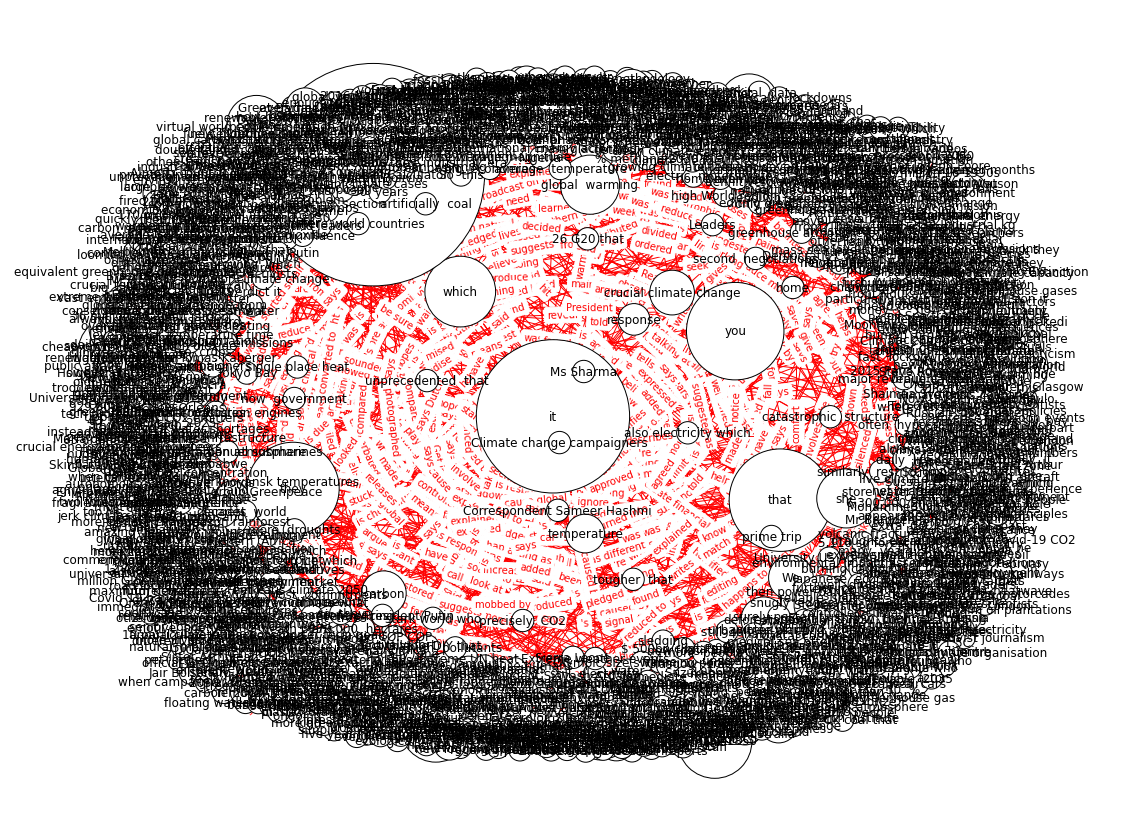

In [26]:
draw_kg_v2(kg_spacy)

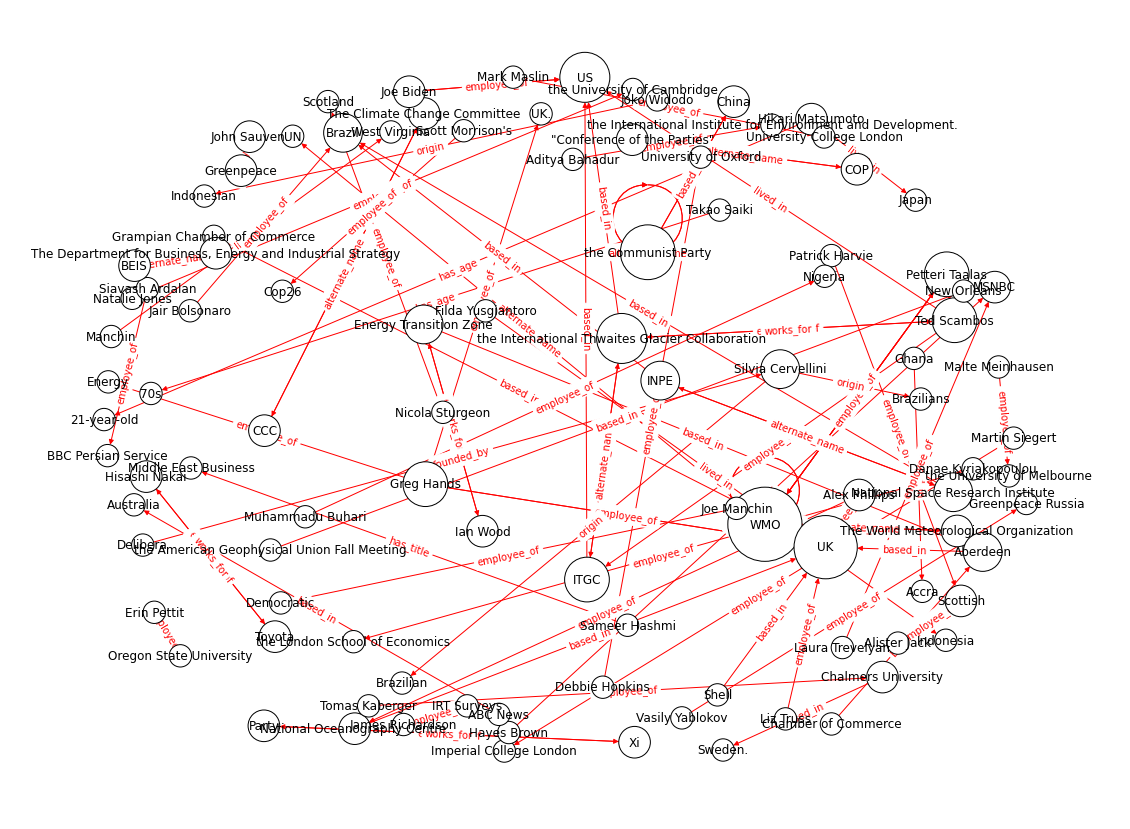

In [27]:
draw_kg_v2(kg_flair)

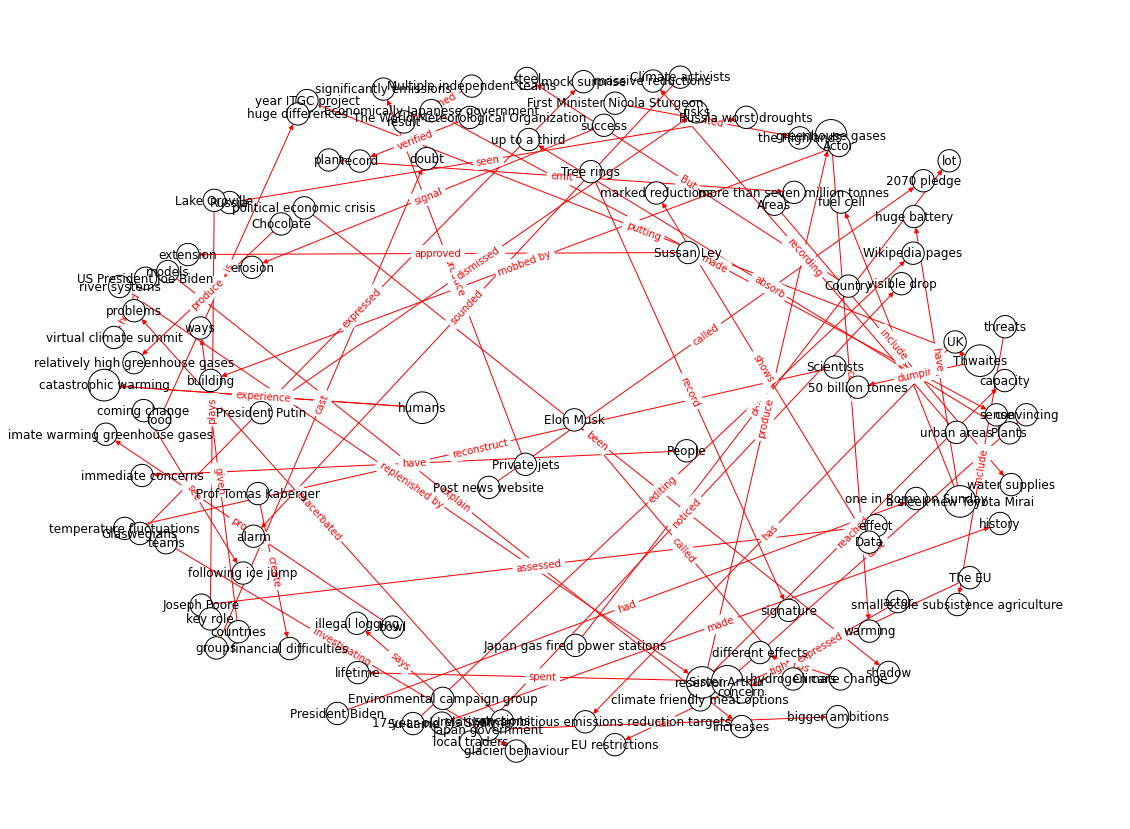

In [28]:
draw_kg(kg_coref)

In [16]:
def filter_graph(pairs, node):
    k_graph = nx.from_pandas_edgelist(pairs, 'subject', 'object',
            create_using=nx.MultiDiGraph())
    edges = nx.dfs_successors(k_graph, node)
    nodes = []
    for k, v in edges.items():
        nodes.extend([k])
        nodes.extend(v)
    subgraph = k_graph.subgraph(nodes)
    layout = (nx.random_layout(k_graph))
    nx.draw_networkx(
        subgraph,
        node_size=1000,
        arrowsize=20,
        linewidths=1.5,
        pos=layout,
        edge_color='red',
        edgecolors='black',
        node_color='white'
        )
    labels = dict(zip((list(zip(pairs.subject, pairs.object))),
                    pairs['relation'].tolist()))
    edges= tuple(subgraph.out_edges(data=False))
    sublabels ={k: labels[k] for k in edges}
    nx.draw_networkx_edge_labels(subgraph, pos=layout, edge_labels=sublabels,
                                font_color='red')
    plt.axis('off')
    plt.show()

In [29]:
unique, counts = np.unique(kg_new['subject'], return_counts=True)

In [31]:
counts

array([ 1,  3,  3,  3,  3,  3,  3,  6,  6,  3,  6,  6,  6,  3,  3,  3,  3,
        3,  3,  3,  3,  3,  6,  3,  3,  2,  1,  6,  4,  6,  3,  3,  3, 12,
        3,  3,  6,  3,  3,  4,  3,  7,  3,  3,  6,  3,  3,  3,  3,  1,  6,
        3,  3,  6])

In [30]:
unique

array(['17-year-old Ms Sharma', 'Areas', 'Chocolate', 'Climate activists',
       'Climate change', 'Country', 'Data',
       'Economically Japanese government', 'Elon Musk',
       'Environmental campaign group', 'First Minister Nicola Sturgeon',
       'Japan gas fired power stations', 'Japan government',
       'Joseph Poore', 'Lake Oroville', 'Multiple independent teams',
       'People', 'Plants', 'Post news website', 'President Biden',
       'President Putin', 'Private jets', 'Prof Tomas Kaberger', 'Russia',
       'Scientists', 'Sister Arthur', 'Sussan Ley', 'The EU',
       'The World Meteorological Organization', 'Thwaites', 'Tree rings',
       'UK', 'US President Joe Biden', 'a sleek new Toyota Mirai', 'bowl',
       'climate friendly meat options', 'coming change', 'countries',
       'food', 'greenhouse gases', 'groups', 'humans', 'local traders',
       'models', 'plant', 'political economic crisis', 'reservoir',
       'river systems', 'sanctions', 'success', 'teams', '

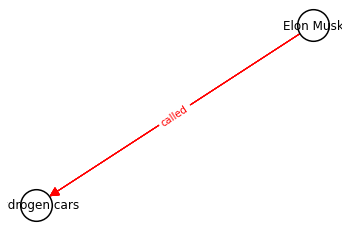

In [40]:
filter_graph(kg_new,'Elon Musk')